# Fast predictive model-building with Apache Spark ML, DataFrames and Python

This article serves as a brief introduction to anyone interested in building predictive models with the Spark.ML library by walking through an example of building a simple recommendation engine. Whilst Spark's machine learning libraries are not as mature as single node libraries such as the excellent scikit-learn, each new release brings a raft of additional features that increasingly make it a realistic option for developing and deploying predictive models in production environments, and at scale. Spark MLlib has been around for quite a while, but a newer library, Spark.ML is now the focus of most new development (according the [this JIRA](https://issues.apache.org/jira/browse/SPARK-12626)), and  in the last few releases (1.4 - 1.6), many of the features that were previously only available in Scala/Java, have being ported to Python.  

What ML offers over MLlib is tight integration with DataFrames, SparkSQL and the concept of Data Pipelines, designed to ease the process of chaining together complex data wrangling steps. I'm not going to go into the details here, they're explained at length [elsewhere](https://spark.apache.org/docs/latest/ml-guide.html), but I belive what these buy you is simplification and more automation of some of the more time consuming tasks of predictive modelling---data manipulation, feature engineering, hyperparameter tuning and model deployment. Spark DataFrames also benefit from optimisation of the execution plan via [Catalyst](https://databricks.com/blog/2015/04/13/deep-dive-into-spark-sqls-catalyst-optimizer.html) that should make them [faster](http://www.adsquare.com/comparing-performance-of-spark-dataframes-api-to-spark-rdd/) and more space efficient compared to standard RDDs, especially in [Python](http://0x0fff.com/spark-dataframes-are-faster-arent-they/) where RDDs incur additional overhead. Since DataFrames and Pipelines were inspired by similar concepts in Python and R, the syntax should feel very familiar to Data Analyts/Scientists coming from those languages. 

In this Jupyter notebook I'm going to showcase some of the features of Spark.ML by walking through the development steps of a movie recommender based on [MovieLens](http://grouplens.org/datasets/movielens/), a commonly used dataset for testing recommenders that contains millions of user ratings of popular movies. Although small samples of MovieLens are often used for pedagogic purposes, I'm going use the full, up-to-date (as of Jan 2016) dataset that contains 22 million ratings of 33,000 movies made by 242,000 users to further underline the benefits why it's worth considering a scalable platform like Spark where data volumes or throughput is non-trivial. Whilst this particular dataset is not genuinely massive, it's still too large to execute comfortably on my laptop, so instead I'm going to run it on a small cluster deployed on Amazon Web Services that is quick and inexpensive to set up, costing about the same as a decent cup of coffee for a few hours of experimentation. A really handy feature is that I can still continue to develop my workflow in the Jupyter notebook in my browser as I might do in a stand-alone environment, and thus benefit from things like integrated code, documentation and data visualiazion all in one document, whilst all of the heavy lifting takes place in the cloud.

The result is a workflow that is straightforward to set-up, code that is concise but readable, opportunities to explore data interactively and automate some of the more tedious aspects of model building, and a solution that scales out for deployment in large-scale environments. 

## Getting Started

I'm going to use an AWS cluster to process the data. The Spark distribution provides a pre-written script to be run from the command line that will provision a cluster of EC2 instances and install Spark running in stand-alone mode. However, in this instance, I'm using Amazon's managed hadoop service Elastic Map Reduce (EMR) that I've set up through the AWS Console in my browser, which walks me through the options available and then installs the neccessary software automatically, running atop Hadoop and Yarn ([see here](https://blogs.aws.amazon.com/bigdata/post/Tx6J5RM20WPG5V/Building-a-Recommendation-Engine-with-Spark-ML-on-Amazon-EMR-using-Zeppelin) for how). By default, EMR picks up the latest release of Spark, which is 1.6. Most of the code below requires at least versions 1.4 or 1.5 to run. 

I've set it up my cluster with 4 worker nodes and a master node that uses m3.xlarge nodes by default, which means 4 virtual CPUs, 15Gb of RAM per node. Now, the cost of provisioning a cluster on demand is around \$ 0.266 an hour per node, which for a decent-sized cluster can soon mount up. So instead, I'm using spot instance pricing, which at the time of execution, was around \$ 0.04 - \$ 0.05 per hour per node. EMR also incurs a fixed charge of around \$ 0.07 per instance per hour, and there is a small charge for data storage on S3. Finally I've installed Jupyter notebook on the master node so I can execute code interactively through the notebook in my browswer - see [here](http://blog.insightdatalabs.com/jupyter-on-apache-spark-step-by-step/) for how). Of course most of my code devlopment and data exploration was done locally on my laptop with a small data sample because I didn't want to rack up uneccessary AWS charges. However, once my code was ready to run on the full dataset, the only coding change required to run on the cluster was to point the load program to the larger datasets on S3 rather than my sample on local storage.


## Loading the data

The latest version of the MovieLens data is formatted as csv files, and comes with a header row of named columns. There is no built-in function in Spark to load csv files directly into a DataFrame like there is in Pandas. One can load it into a conventional RDD with sc.textFile() and extract the fields in the conventional way with the map(lambda line: line.split(',') pattern, and then do the type conversions, convert it to a DataFrame, rename the resulting columns,and filter out the first line containing the column headers...and so on. So I find it more convenient to use the third party [csv package](https://github.com/databricks/spark-csv) from Databricks that will acomplish all of this in one step. The option 'inferschema' should cast the columns to the correct data type by scanning the first few rows of the file.

The MovieLens dataset contains four files in total, but I'm only going to need two of them here. 'Ratings' contains the 22 million ratings (from 0 to 5) with integer keys to identify the user who provided the rating and the identity of the movie they rated. 'Movies' is a lookup table that maps the movie integer id in 'Ratings' to the full text name of the movie title, and a list of movie genres it belongs to.

In [1]:
from __future__ import print_function, division
from pyspark import SparkConf, SparkContext
from pyspark.sql import HiveContext
from pyspark.sql.types import *

sqlContext = HiveContext(sc)
ratings = sqlContext.read \
    .format("com.databricks.spark.csv") \
    .options(header = True, delimiter=',') \
    .load('s3n://sg-ml-latest/ratings.csv', inferschema = True)

movies = sqlContext.read \
    .format("com.databricks.spark.csv") \
    .options(header = True, delimiter=',') \
    .load('s3n://sg-ml-latest/movies.csv',  inferschema = True)

In [2]:
ratings.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    135|   3.0|1278471458|
|     1|   1347|   4.0|1278471439|
|     1|   1441|   4.0|1278471475|
|     1|   2080|   3.0|1278471407|
|     1|   2827|   3.0|1278471579|
+------+-------+------+----------+
only showing top 5 rows



In [4]:
ratings.count()

22775244

In [5]:
ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [6]:
movies.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [7]:
movies.count()

33869

In [8]:
movies.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



## Exploratory Data Analysis

Before I dive in to building models, I'm going to take a brief exploratory look at the data. DataFrames and SparkSQL provide a glut of new convenience functions that allow data transformations such as datetime functions, window functions and basic descriptive statistics. There is a DataFrames API that  exposes these convenience functions as method calls in what is a SQL-like DSL, or alternatively one can to just pass a complete SQL or Hive expression as a string to the SQL function. I'll (unashamedly) alternate between both styles as I go along. Let's start by looking at the vintage of the ratings within each year, and the spread of those rating scores. The 'timestamp' field is in Unix time, so first I'm going to convert it into a more human-readable date and rename it 'ratingDate':

In [9]:
#Convert a unixtimestamp to a readable date/time
ratings_trans = ratings.select(ratings.userId, 
                         ratings.movieId,
                         ratings.rating, 
                         pyspark.sql.functions.from_unixtime(ratings.timestamp).alias('ratingDate'))
ratings_trans.show(5)

+------+-------+------+-------------------+
|userId|movieId|rating|         ratingDate|
+------+-------+------+-------------------+
|     1|    135|   3.0|2010-07-07 02:57:38|
|     1|   1347|   4.0|2010-07-07 02:57:19|
|     1|   1441|   4.0|2010-07-07 02:57:55|
|     1|   2080|   3.0|2010-07-07 02:56:47|
|     1|   2827|   3.0|2010-07-07 02:59:39|
+------+-------+------+-------------------+
only showing top 5 rows



Now let's look at the number of ratings generated in each year. This time I want to chart the pattern, so I'm going to take the query result set and bring it back to the driver program and store it in a local Pandas dataframe with toPandas() so I can chart it using matplotlib and display it in this notebook. It seems there is a fairly even spread of ratings from 1996-2015 so I would expect a reasonable representation from movies released across that 20 year period:

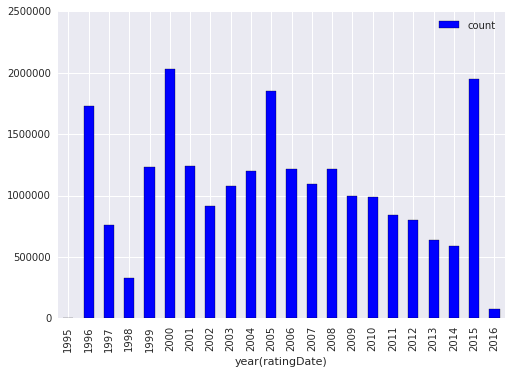

In [10]:
%matplotlib inline  
import seaborn
ratings_trans.groupBy(pyspark.sql.functions.year(ratings_trans.ratingDate)) \
    .count() \
    .toPandas() \
    .plot.bar(x='year(ratingDate)')
    

I can get a quick breakdown of the ratings field with describe().It seems the lowest rating that can be given is half a point, not zero as I'd previously thought, and the maximum is five:

In [11]:
ratings.describe('rating').show()

+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|          22775244|
|   mean| 3.525978184909896|
| stddev|1.0610787423393457|
|    min|               0.5|
|    max|               5.0|
+-------+------------------+



Let's see how many ratings each movie has attracted. The movieId is not very informative on its own, so I'll need to join it to the movies lookup table in order to see the titles:

In [12]:
rating_counts = ratings.groupBy(ratings.movieId) \
    .count() \
    .join(movies, ratings.movieId == movies.movieId) \
    
rating_counts.show(5)

+-------+-----+-------+--------------------+--------------------+
|movieId|count|movieId|               title|              genres|
+-------+-----+-------+--------------------+--------------------+
|     31|11247|     31|Dangerous Minds (...|               Drama|
|    231|35484|    231|Dumb & Dumber (Du...|    Adventure|Comedy|
|    431|10118|    431|Carlito's Way (1993)|         Crime|Drama|
|    631| 2552|    631|All Dogs Go to He...|Adventure|Animati...|
|    831|  226|    831|    Stonewall (1995)|               Drama|
+-------+-----+-------+--------------------+--------------------+
only showing top 5 rows




So, the average number of ratings per move is 683, but the spread is quite wide---some attract tens of thousands and others as few as a single rating:

In [13]:
rating_counts.select('count').describe().show()

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|             33336|
|   mean|  683.202663786897|
| stddev|3148.7155091046634|
|    min|                 1|
|    max|             80913|
+-------+------------------+



The most frequently rated movies are fairly obvious:

In [14]:
rating_counts.sort('count', ascending=False).show(5)

+-------+-----+-------+--------------------+--------------------+
|movieId|count|movieId|               title|              genres|
+-------+-----+-------+--------------------+--------------------+
|    356|80913|    356| Forrest Gump (1994)|Comedy|Drama|Roma...|
|    296|78740|    296| Pulp Fiction (1994)|Comedy|Crime|Dram...|
|    318|77367|    318|Shawshank Redempt...|         Crime|Drama|
|    593|75973|    593|Silence of the La...|Crime|Horror|Thri...|
|    480|69401|    480|Jurassic Park (1993)|Action|Adventure|...|
+-------+-----+-------+--------------------+--------------------+
only showing top 5 rows



Sorting the DataFrame in the opposite direction reveals the least popular movies that have only been rated once. 
Movies with so few ratings can prove problematic to the recommender - we can't say much about the quality of the movie or who it is appropriate for based on a single rating, and it will also introduce a subtle bug into our test sets (see later).
So I will be filtering out these unpopular movies from my working datasets in due course.

In [15]:
rating_counts.sort('count', ascending=True).show(5)

+-------+-----+-------+--------------------+------------------+
|movieId|count|movieId|               title|            genres|
+-------+-----+-------+--------------------+------------------+
|  48235|    1|  48235|Flight from Death...|       Documentary|
|  27235|    1|  27235|Shrink Is In, The...|    Comedy|Romance|
|  72235|    1|  72235|Between the Devil...|             Drama|
| 102035|    1| 102035| Holding, The (2011)|   Horror|Thriller|
|  77435|    1|  77435|This Is the Army ...|Comedy|Musical|War|
+-------+-----+-------+--------------------+------------------+
only showing top 5 rows



Finally, let's look at how many ratings each user has submitted:

In [16]:
user_counts = ratings.groupBy(ratings.userId).count()
user_counts.select('count').describe().show()

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|            246829|
|   mean| 92.27134574948649|
| stddev|193.05029790942856|
|    min|                 1|
|    max|              9281|
+-------+------------------+



We can see that the mean is 92 reviews, but this is influenced by a few enthusiasts who rate thousands of movies - the distribution is very positively skewed so most users rate far less than the average. There is no explicit median() function, but I can use the percentile function from Hive to do the job:

In [17]:
user_counts.registerTempTable('user_counts')
sqlContext.sql("""
    select percentile(count, 0.25) as lower_q,
    percentile(count, 0.5) as median, 
    percentile(count, 0.75) as upper_q
    from user_counts""").show()

+-------+------+-------+
|lower_q|median|upper_q|
+-------+------+-------+
|   15.0|  29.0|   89.0|
+-------+------+-------+



## Building the first recommender model

Time to start building models. In order to do this I'm going to create a test/hold-out dataset for evaluating the quality of my final model at the end of the process by spliting the data into two parts with randomSplit(). But first,
I'm going to filter out movies and users that have provided very low numbers of ratings. I might be inclined to do this for reasons of model robustness, but the more practical reason I'm doing here is an implementation detail - the job will fail if I don't. The reason is due to the random allocation of observations to the training and test datasets. If I have ratings of particular movies or users that get allocated to the test set that, because of their low numbers, don't have a corresponding example in the training set, then the model doesn't know how to calculate a prediction for them and instead returns a Nan value. Consequently, when RegressionEvalutor attempts to calculate the RMSE across the test data, if it discovers a Nan in the model predictions, it also will return Nan as the result. As we will see in the next section, RegressionEvaluator is also used as part of the hyperparameter tuning process to compare various models in the cross-validation step, which also involves splitting the train dataset into multiple folds for model building and validation, so this process will also fail. 

In [3]:
ratings.registerTempTable('ratings')
filtered_ratings = sqlContext.sql("""
    select
    a.*
    from ratings a 
    inner join (select movieId from ratings group by movieId having count(*) > 10 ) b
    on a.movieId = b.movieId
    inner join (select userId from ratings group by userId having count(*) > 10) c
    on a.userId = c.userId
""")

print('ratings before filter applied:', ratings.count())
print('ratings after filter applied:', filtered_ratings.count())

ratings before filter applied: 22775244
ratings after filter applied: 22500271


In [4]:
train, test = filtered_ratings.randomSplit([0.7,0.3])
train.cache()
test.cache()

DataFrame[userId: int, movieId: int, rating: double, timestamp: int]

The only appropriate recommendation algorithm in this scenario that is built into Spark is Alternating Least Squares which implements factorisation of the User/Item matrix. I need to specify which columns represent the rating, user, and and movie identifier. There are some model hyperparameters that can be set in the call to ALS, but I will leave them at their defaults for now and come back to them in the next section. Calling fit() will return a model fitted with the training dataset I pass to it. The wall clock time of this fit produre on c.15 million ratings was around 2 minutes on my EMR cluster.


In [10]:
from pyspark.ml.recommendation import ALS
als = ALS(userCol = 'userId', itemCol = 'movieId', ratingCol = 'rating')
model1 = als.fit(train)


Now, calling model.transform() on the trained model and this time passing it the test data will generate predictions for the previously unseen observations. The resulting column is called 'prediction' and we can easily compare it to the the rating the user actually gave to check how good the model predictions are. For the first observation, the model  overestimates the true user rating by 1.46, the second by 0.35, and so on:


In [11]:
predictions= model1.transform(test)
predictions.withColumn('error', predictions.prediction - predictions.rating).show(5)


+------+-------+------+----------+----------+--------------------+
|userId|movieId|rating| timestamp|prediction|               error|
+------+-------+------+----------+----------+--------------------+
|  1636|     31|   1.0|1085698669| 2.4686809|  1.4686808586120605|
| 19436|     31|   3.0|1121817600| 3.3585715| 0.35857152938842773|
| 24636|     31|   5.0| 884344250| 3.4005303| -1.5994696617126465|
| 28236|     31|   3.0|1081396536|  3.313393| 0.31339311599731445|
| 31236|     31|   4.0| 837955631|  3.815868|-0.18413209915161133|
+------+-------+------+----------+----------+--------------------+
only showing top 5 rows



## Finding the best model through hyperparameter tuning

The first model used the default settings, but now I want to find the best peforming model by adjusting the parameters of the algorithm, such as the rank (i.e. number of latent factors to extract), and the regularization penalty. This can be done by trial and error, but more systematically by building a parameter grid, which will allow me to specify a range of parameter setttings for multiple hyperparameters, and then exhaustively test all possible combinations. 

I also need to specify an evaluation metric to summarise the prediction errors across the test dataset as a whole that will allow comparison between the numerous models I'm about to generate. There are different kinds of metrics used for evaluation recommendation quality, but the only relevant ones that are currently implemented in ML are those that are used to evaluate standard regression problems, so here I'm using Root Mean Squared Error (RMSE). 

Finally, I'm using cross validation with 5 folds, and even though my range for each hyperparameter has been set small in this example, the process will still generate a lot of candidate models and be fairly computationally expensive. However the total runtime was around 1 hour on my EMR cluster.

In [13]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.param import Param, Params
from pyspark.ml import Pipeline
from pyspark.ml.tuning import *
als =  ALS(userCol = 'userId', itemCol = 'movieId', ratingCol = 'rating')
param_grid = ParamGridBuilder() \
    .addGrid(als.regParam, [0.1, 0.01]) \
    .addGrid(als.rank, [10, 20, 40, 60]) \
    .build()
    
    
cv = CrossValidator() \
    .setEstimator(als) \
    .setEstimatorParamMaps(param_grid) \
    .setEvaluator(RegressionEvaluator(predictionCol="prediction", labelCol="rating",  metricName="rmse")) \
    .setNumFolds(5)
    
cv_model = cv.fit(train)


The cv_model object retains the details of the best performing model on the cross validation process. So finally, I finish by calculating the error of the best performing model on the test set that hitherto, has not been used in model selection and should provide an unbaised estimate of real-word performance on unseen data:

In [14]:
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="rating",  metricName="rmse")
evaluator.evaluate(cv_model.bestModel.transform(test))


0.7811422347004146

## What would you recommend?

By way of a more concrete example, let's pick a user at random and analyse what recommendations the algorithm would've made for them, based on how they've rated other movies. The code returns the top 20 predictions tailored to this user from the test dataset based on the learned ALS model. The highest recommendationare are Shawshank, Godfather 2, Raiders of the Lost Ark etc, which correlates closely with their actual ratings, so intial prognosis is that the recommendations are not too bad.

In [21]:
cv_recommmendations = cv_model.bestModel.transform(test)
example_recommendations = cv_recommmendations.filter(cv_recommmendations.userId==23) \
    .join(movies, cv_recommmendations.movieId == movies.movieId) \
    .select('userId', cv_recommmendations.movieId, 'title', 'genres', 'rating', 'prediction') \
    .orderBy('prediction', ascending=False) \
    .show()


+------+-------+--------------------+--------------------+------+----------+
|userId|movieId|               title|              genres|rating|prediction|
+------+-------+--------------------+--------------------+------+----------+
|    23|    318|Shawshank Redempt...|         Crime|Drama|   4.0| 4.5498276|
|    23|   1221|Godfather: Part I...|         Crime|Drama|   5.0|   4.47567|
|    23|   1193|One Flew Over the...|               Drama|   5.0|  4.392229|
|    23|   1198|Raiders of the Lo...|    Action|Adventure|   5.0|  4.353747|
|    23|   1207|To Kill a Mocking...|               Drama|   5.0| 4.3274226|
|    23|   1234|   Sting, The (1973)|        Comedy|Crime|   5.0| 4.3210397|
|    23|   1233|Boot, Das (Boat, ...|    Action|Drama|War|   5.0| 4.3163137|
|    23|    720|Wallace & Gromit:...|Adventure|Animati...|   3.0| 4.2668924|
|    23|   4973|Amelie (Fabuleux ...|      Comedy|Romance|   4.0|  4.264877|
|    23|    903|      Vertigo (1958)|Drama|Mystery|Rom...|   4.0| 4.2496524|

Finally (just for fun) let's look at the recommender's predictions based on movies the user genuinely hasn't rated yet, and then cast a subjective eye over what would be recommended if we were to deploy the algorithm today. For this example I'm going back the the original ratings dataset (before I split it into 2) to filter out all of the user's previously rated movies from the result set.

In [26]:
movies_seen = filtered_ratings.filter(filtered_ratings.userId==23).select('movieId')
allmovies = movies.select('movieId')
movies_ids_to_be_seen =  allmovies.subtract(movies_seen)

movies_ids_to_be_seen.registerTempTable('movie_ids_to_be_seen')
movies.registerTempTable('movies')
                        
movies_to_be_seen = sqlContext.sql("""
    select a.movieId, 23 as userId, b.title, b.genres
    from movie_ids_to_be_seen a 
    inner join movies b 
    on a.movieId = b.movieId""")

movies_rated =cv_model.bestModel.transform(movies_to_be_seen)


...and the results are...unexpected! Fascinating to see lots of documentaries and stand-up comedy acts, but at some point I'm going to have to delve deeper into the user's existing ratings profile to try to work out why these predictions were made.

In [28]:
movies_rated.orderBy('prediction', ascending = False).dropna().show()


+-------+------+--------------------+--------------------+----------+
|movieId|userId|               title|              genres|prediction|
+-------+------+--------------------+--------------------+----------+
| 100511|    23|House Is Black, T...|         Documentary| 4.7685204|
|  94735|    23|Walking with Mons...|         Documentary| 4.6351557|
|  69483|    23|Not on Your Life ...|        Comedy|Drama| 4.6293344|
| 139100|    23|Once Brothers (2010)|         Documentary| 4.6274576|
|  92498|    23|Dylan Moran Live:...|              Comedy| 4.6191936|
| 116975|    23|Long Way Round (2...|Adventure|Documen...| 4.6186757|
| 101850|    23|Death on the Stai...|   Crime|Documentary| 4.6130514|
| 113474|    23|Autobiography of ...|               Drama| 4.6003656|
|  88067|    23|Happiness Is a Wa...|    Animation|Comedy|  4.572539|
| 118468|    23|Mei and the Kitte...|   Animation|Fantasy|  4.568615|
|  96471|    23|Prime Suspect 3 (...| Crime|Drama|Mystery| 4.5386686|
|  26941|    23|Pret

## Conclusions

I've given a brief demonstration of model building in the new Spark ML API. I hope you'll agree that the resulting code is straightforward and familar in style to Data Analyts/Scientists who code in Python, R or SQL and, to some tastes, preferable to the approach taken by MLlib. Althought there are still weaknesses in the library in its current incarnation, some of these issues are likely to be addressed in the [next release]((https://issues.apache.org/jira/browse/SPARK-12626). I like that fact that I can integrate so many stages of the modelling lifecycle into one environment, using a language of my choice, and then deploy it at scale should I need to. The MovieLens dataset is a relatively clean and easy dataset to process, so complex data wrangling was not required in this case (and if it were it wouldn't make for easy reading), but the ML and SparkSQL API now contains dozens of convenience functions that make this often tedious process easier than it might be otherwise. 
